In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# Set a nice style for the plots
sns.set_theme(style="whitegrid")
print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
def load_sota_results(filepath: str) -> pd.DataFrame:
    """
    Dynamically loads tabular data, automatically detecting the separator
    based on the file extension (.tsv, .csv, etc.).
    """
    print(f"Loading SOTA results from: {filepath}")
    
    # Get the file extension from the path
    file_extension = Path(filepath).suffix.lower()
    
    # Choose the separator based on the extension
    if file_extension == '.tsv':
        separator = '\t'
    elif file_extension == '.csv':
        separator = ','
    else:
        # For any other extension, let pandas try to auto-detect.
        # This is often successful for simple, well-formatted files.
        separator = None
        print(f"Warning: Unrecognized extension '{file_extension}'. Letting pandas auto-detect the separator.")
        
    return pd.read_csv(filepath, sep=separator)

def load_single_run_results(results_folder: str, run_name: str) -> pd.DataFrame:
    """Loads the Spearman correlation results for a single, specified run."""
    filepath = Path(results_folder) / run_name / "tsplice_spearman_by_tissue.tsv"
    print(f"Loading single run results from: {filepath}")
    
    # Load the tab-separated file
    df = pd.read_csv(filepath, sep='\t')
    
    # --- ADDED THIS STEP ---
    # Standardize column names to match the expected format ('spearman_rho_...')
    # This handles files that might have the older 'spearman_psi' naming.
    rename_dict = {
        'spearman_psi': 'spearman_rho_psi',
        'spearman_delta': 'spearman_rho_delta_psi'
    }
    df.rename(columns=rename_dict, inplace=True)
    
    return df

def load_and_average_all_runs(results_folder: str) -> pd.DataFrame:
    """
    Finds all 'run_*' directories, loads their results, and computes the mean 
    and standard deviation for performance metrics across all runs.
    """
    all_run_dfs = []
    results_path = Path(results_folder)
    
    run_dirs = sorted([d for d in results_path.iterdir() if d.is_dir() and d.name.startswith('run_')])
    print(f"Found {len(run_dirs)} run directories to average.")

    for run_dir in run_dirs:
        filepath = run_dir / "tsplice_spearman_by_tissue.tsv"
        if filepath.exists():
            df = pd.read_csv(filepath, sep='\t')
            # Handle potential inconsistencies in column naming from your images
            df = df.rename(columns={'spearman_psi': 'spearman_rho_psi', 'spearman_delta': 'spearman_rho_delta_psi'})
            all_run_dfs.append(df)
        else:
            print(f"Warning: Did not find results file in {run_dir}")

    if not all_run_dfs:
        print("Error: No result files were found to average.")
        return pd.DataFrame()

    # Concatenate all dataframes into one
    combined_df = pd.concat(all_run_dfs)
    
    # Group by tissue and calculate mean and standard deviation
    averaged_results = combined_df.groupby('tissue').agg(
        mean_spearman_rho_psi=('spearman_rho_psi', 'mean'),
        std_spearman_rho_psi=('spearman_rho_psi', 'std'),
        mean_spearman_rho_delta_psi=('spearman_rho_delta_psi', 'mean'),
        std_spearman_rho_delta_psi=('spearman_rho_delta_psi', 'std')
    ).reset_index()
    
    print("Successfully averaged results across all runs.")
    return averaged_results

print("Data loading functions defined.")

Data loading functions defined.


In [3]:
def _prepare_single_model_df(df, metric, model_name):
    """Internal helper to prepare one DataFrame for comparison."""
    is_averaged = f'mean_{metric}' in df.columns
    metric_col = f'mean_{metric}' if is_averaged else metric
    std_col = f'std_{metric}' if is_averaged else None

    cols_to_select = ['tissue', metric_col]
    if is_averaged and std_col and std_col in df.columns:
        cols_to_select.append(std_col)
    
    plot_df = df[cols_to_select].copy()
    plot_df.rename(columns={metric_col: model_name}, inplace=True)
    return plot_df

def prepare_grouped_plot_data(df1, df2, metric, model1_name, model2_name):
    """
    Prepares and merges data from two models for a grouped bar plot.

    Args:
        df1 (pd.DataFrame): DataFrame for the first model.
        df2 (pd.DataFrame): DataFrame for the second model.
        metric (str): The base metric name (e.g., 'spearman_rho_psi').
        model1_name (str): Custom name for the first model.
        model2_name (str): Custom name for the second model.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: A tuple containing:
            - comparison_df: The merged, wide-format DataFrame.
            - melted_df: The long-format DataFrame ready for seaborn.
    """
    model1_plot_df = _prepare_single_model_df(df1, metric, model1_name)
    model2_plot_df = _prepare_single_model_df(df2, metric, model2_name)

    # Merge the two prepared dataframes
    comparison_df = pd.merge(model1_plot_df, model2_plot_df, on='tissue', how='inner')
    
    # "Melt" the dataframe for seaborn plotting
    melted_df = comparison_df.melt(id_vars='tissue', value_vars=[model1_name, model2_name], 
                                   var_name='Model', value_name='Spearman ρ')
    
    return comparison_df, melted_df

In [4]:
def plot_grouped_comparison(comparison_df, melted_df, title, model1_name, model2_name, save_path=None):
    """
    Generates a grouped bar plot from prepared dataframes.

    Args:
        comparison_df (pd.DataFrame): The merged, wide-format DataFrame.
        melted_df (pd.DataFrame): The long-format DataFrame for plotting.
        title (str): The title for the plot.
        model1_name (str): Name of the first model.
        model2_name (str): Name of the second model.
        save_path (str, optional): Path to save the figure.
    """
    plt.figure(figsize=(16, 8))
    ax = sns.barplot(data=melted_df, x='tissue', y='Spearman ρ', hue='Model', 
                     palette={model1_name: 'lightgray', model2_name: 'mediumseagreen'})
    
    # Add error bars if standard deviation data exists for the second model
    std_col = [col for col in comparison_df.columns if col.startswith('std_')]
    if std_col:
        error_map = comparison_df.set_index('tissue')[std_col[0]].to_dict()
        patches = [p for p in ax.patches if p.get_height() > 0]
        model2_bars = patches[len(patches)//2:] # Second model's bars are the second half
        
        for i, bar in enumerate(model2_bars):
            tissue_name = ax.get_xticklabels()[i].get_text()
            error = error_map.get(tissue_name)
            if pd.notna(error):
                ax.errorbar(x=bar.get_x() + bar.get_width() / 2, y=bar.get_height(), yerr=error,
                            fmt='none', capsize=5, color='black')

    plt.title(title, fontsize=18)
    plt.ylabel('Spearman ρ', fontsize=12)
    plt.xlabel('Tissue', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Model')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")

    plt.show()

In [6]:
# 1. Load the SOTA data

# --- Please update these paths ---

# 1. Path to your State-of-the-Art (SOTA) results file.
#    This file should have at least 'tissue', 'spearman_rho_psi', 'spearman_rho_delta_psi' columns.
sota_file_name = "variable_all_tissues_spearman_correlations.tsv"
result_file_name = "exprmnt_2025_08_26__17_44_28"

main_dir = "/gpfs/commons/home/atalukder/Contrastive_Learning/files/results/"
SOTA_FILE_PATH = f"{main_dir}/mtsplice_originalTFweight_results/{sota_file_name}"

# 2. Path to the main folder containing all your experiment runs (e.g., run_1, run_2, etc.)
RESULTS_FOLDER_PATH = f"{main_dir}/{result_file_name}/weights/checkpoints"

# --- End of configuration ---


# sota_results = load_sota_results(SOTA_FILE_PATH)
# print(sota_results.head())

# # --- OPTION A: Analyze a SINGLE RUN (e.g., 'run_1') ---
# print("\n--- Analyzing a Single Run: run_1 ---")
# single_run_results = load_single_run_results(RESULTS_FOLDER_PATH, 'run_23')

In [7]:
# --- Assume these DataFrames are already loaded ---

# SOTA results
sota_results = load_sota_results(SOTA_FILE_PATH)

# Results for a single run
single_run_1_results = load_single_run_results(RESULTS_FOLDER_PATH, 'run_23')
print(single_run_1_results.head())

# # Results for another single run (from a different experiment/user)
# single_run_2_results = load_single_run_results(RESULTS_FOLDER_PATH, 'run_5')

# Averaged results from one set of runs
averaged_run_1_results = load_and_average_all_runs(RESULTS_FOLDER_PATH)

# # Averaged results from another set of runs
# averaged_run_2_results = load_and_average_all_runs(RESULTS_FOLDER_PATH)

Loading SOTA results from: /gpfs/commons/home/atalukder/Contrastive_Learning/files/results//mtsplice_originalTFweight_results/variable_all_tissues_spearman_correlations.tsv
Loading single run results from: /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/exprmnt_2025_08_26__17_44_28/weights/checkpoints/run_23/tsplice_spearman_by_tissue.tsv
                       tissue  spearman_rho_psi  spearman_rho_delta_psi  \
0               Adrenal Gland          0.918793                0.069896   
1            Amygdala - Brain          0.918053               -0.022125   
2  Anterior cingulate - Brain          0.884698               -0.077886   
3              Aorta - Artery          0.921660               -0.139035   
4    Atrial Appendage - Heart          0.910626               -0.096384   

   n_valid_psi  n_valid_delta  
0         1064           1064  
1         1053           1053  
2         1089           1089  
3         1051           1051  
4         1064           1064  


Figure saved to: 1_sota_vs_single_run.png


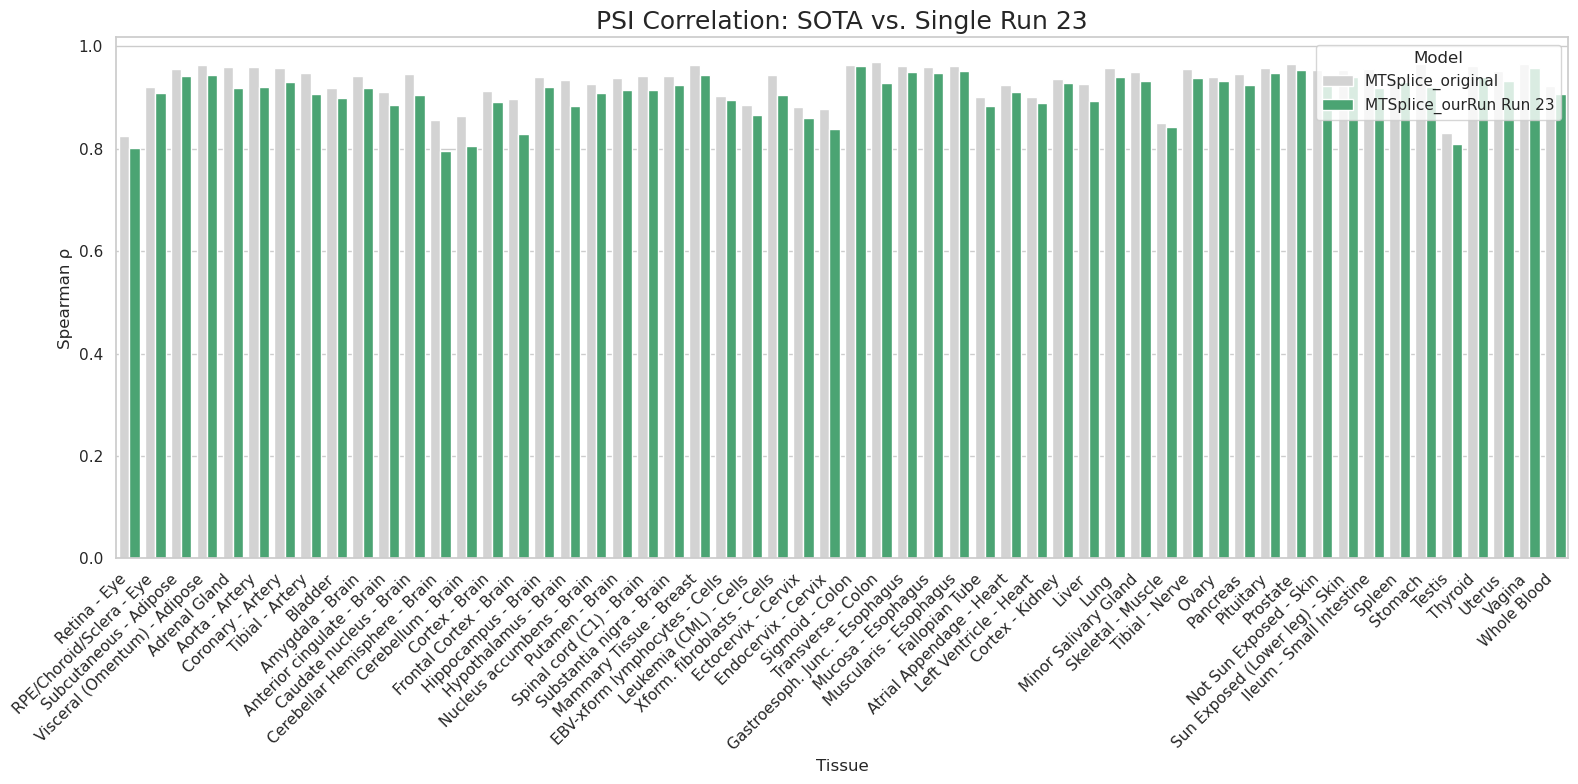

Figure saved to: 1_sota_vs_single_run.png


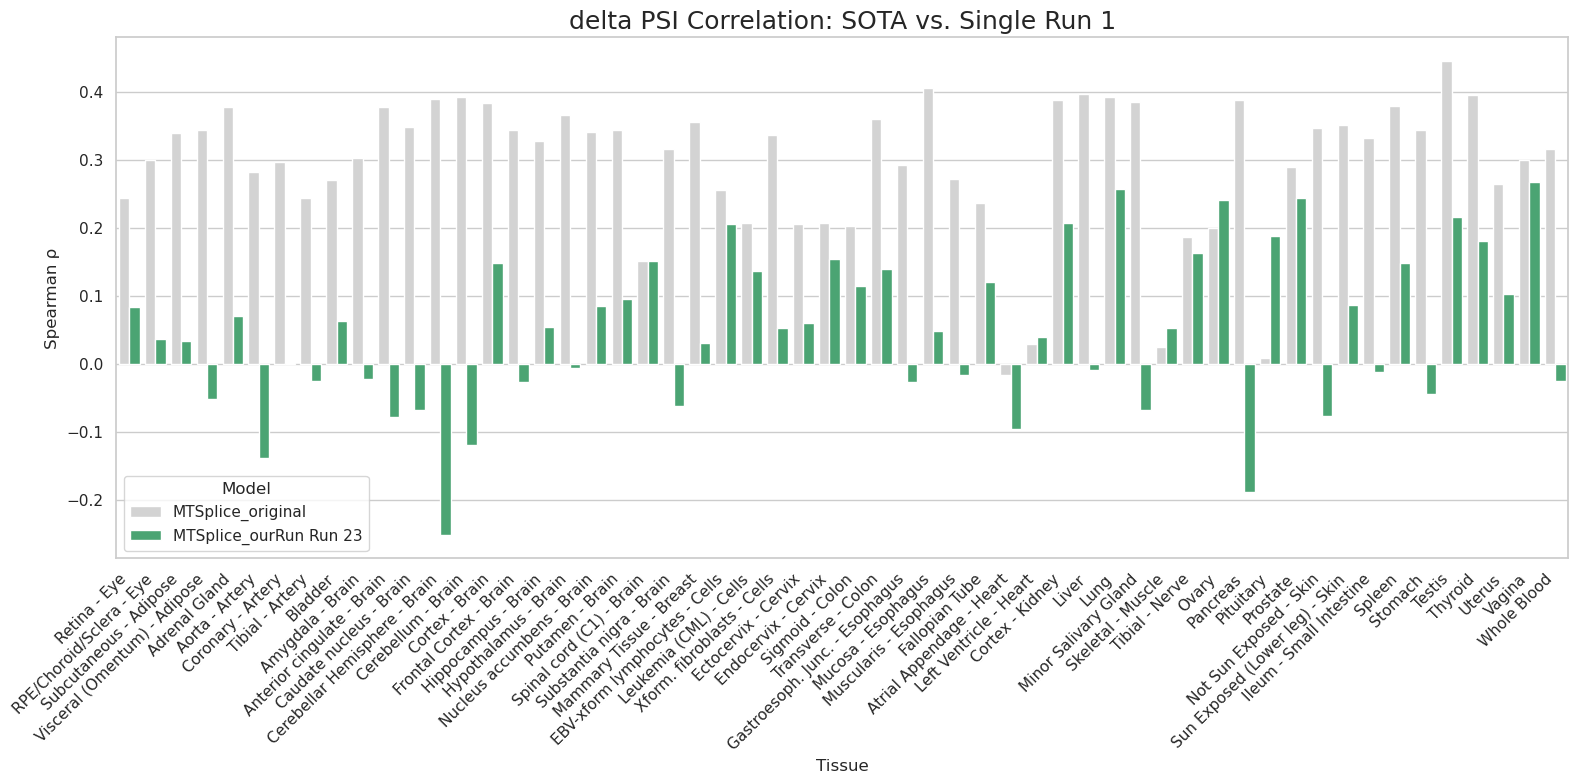

In [10]:
# Prepare the data
comp_df_1, melt_df_1 = prepare_grouped_plot_data(
    df1=sota_results,
    df2=single_run_1_results,
    metric='spearman_rho_psi',
    model1_name='MTSplice_original',
    model2_name='MTSplice_ourRun Run 23'
)

# Create the plot
plot_grouped_comparison(
    comp_df_1, melt_df_1,
    title='PSI Correlation: SOTA vs. Single Run 23',
    model1_name='MTSplice_original',
    model2_name='MTSplice_ourRun Run 23',
    save_path='1_sota_vs_single_run.png'
)

# Prepare the data
comp_df_1, melt_df_1 = prepare_grouped_plot_data(
    df1=sota_results,
    df2=single_run_1_results,
    metric='spearman_rho_delta_psi',
    model1_name='MTSplice_original',
    model2_name='MTSplice_ourRun Run 23'
)

# Create the plot
plot_grouped_comparison(
    comp_df_1, melt_df_1,
    title='delta PSI Correlation: SOTA vs. Single Run 1',
    model1_name='MTSplice_original',
    model2_name='MTSplice_ourRun Run 23',
    save_path='1_sota_vs_single_run.png'
)

Figure saved to: 1_sota_vs_single_run.png


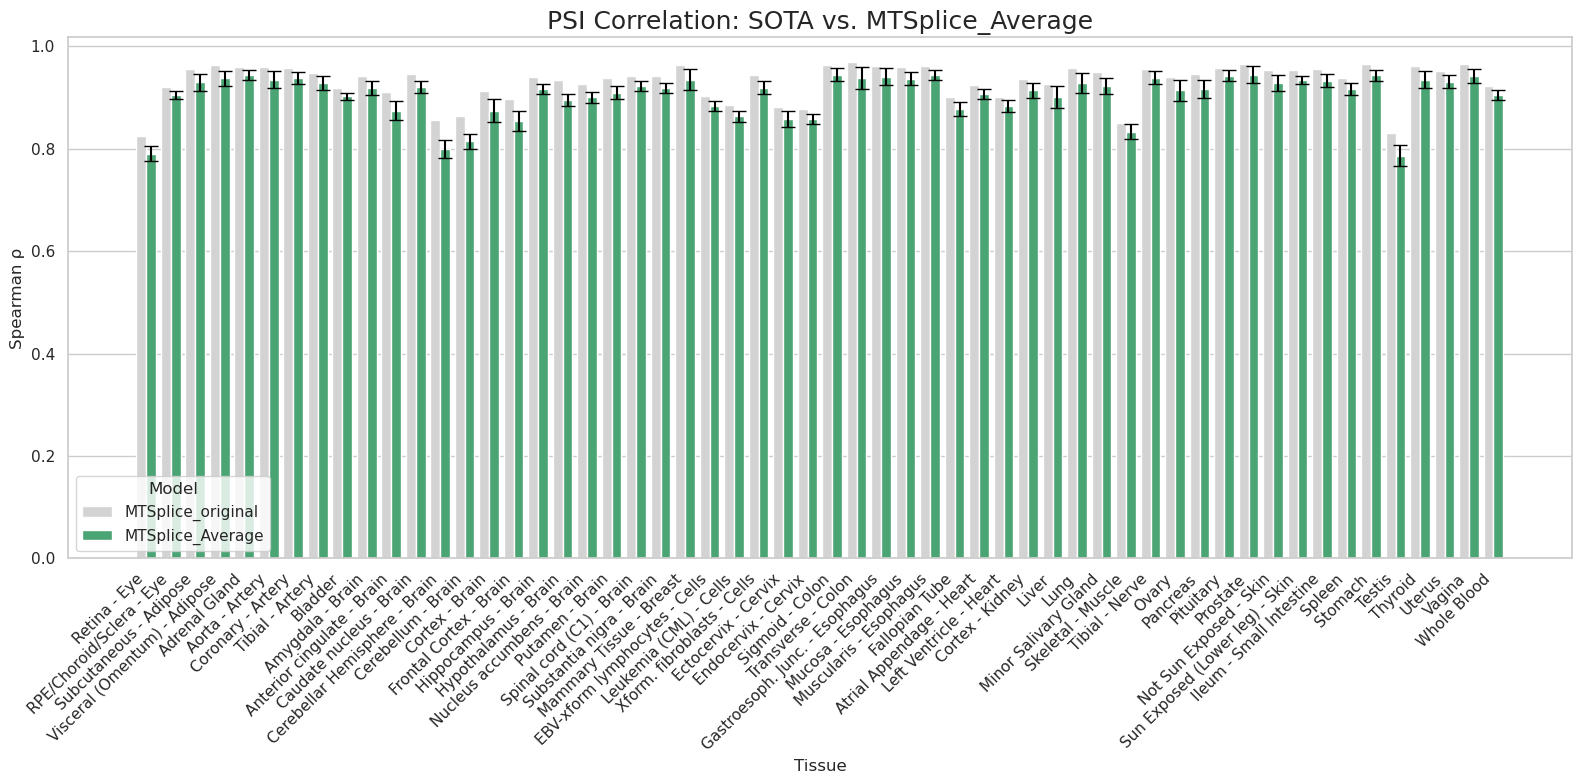

Figure saved to: 1_sota_vs_single_run.png


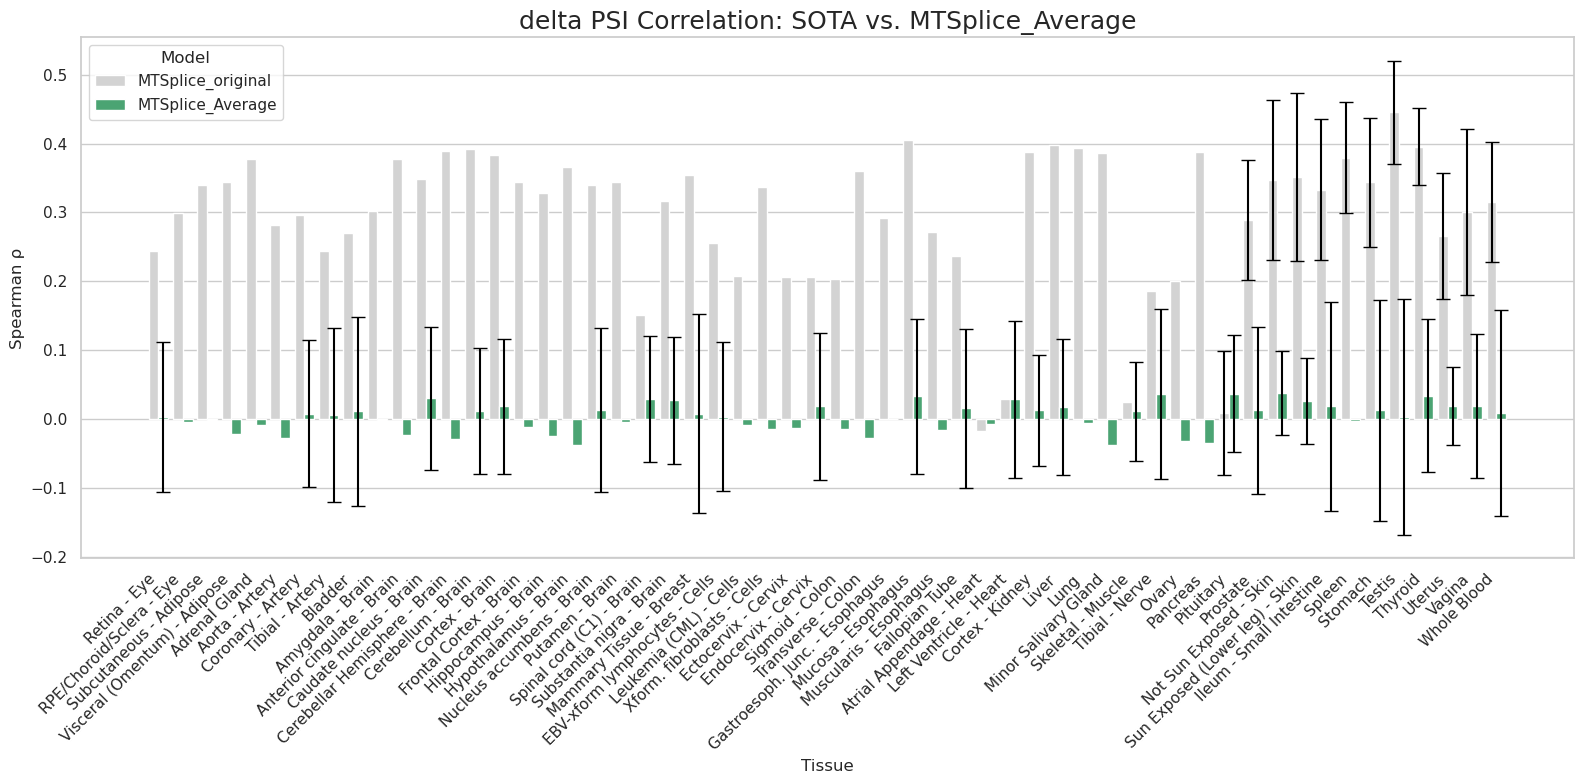

In [16]:
# Prepare the data
comp_df_1, melt_df_1 = prepare_grouped_plot_data(
    df1=sota_results,
    df2=averaged_run_1_results,
    metric='spearman_rho_psi',
    model1_name='MTSplice_original',
    model2_name='MTSplice_Average'
)

# Create the plot
plot_grouped_comparison(
    comp_df_1, melt_df_1,
    title='PSI Correlation: SOTA vs. MTSplice_Average',
    model1_name='MTSplice_original',
    model2_name='MTSplice_Average',
    save_path='1_sota_vs_single_run.png'
)

# Prepare the data
comp_df_1, melt_df_1 = prepare_grouped_plot_data(
    df1=sota_results,
    df2=averaged_run_1_results,
    metric='spearman_rho_delta_psi',
    model1_name='MTSplice_original',
    model2_name='MTSplice_Average',
)

# Create the plot
plot_grouped_comparison(
    comp_df_1, melt_df_1,
    title='delta PSI Correlation: SOTA vs. MTSplice_Average',
    model1_name='MTSplice_original',
    model2_name='MTSplice_Average',
    save_path='1_sota_vs_single_run.png'
)

In [ ]:
######################################

In [ ]:
# Prepare the data
comp_df_2, melt_df_2 = prepare_grouped_plot_data(
    df1=sota_results,
    df2=averaged_run_1_results,
    metric='spearman_rho_psi',
    model1_name='SOTA',
    model2_name='Averaged Model 1'
)

# Create the plot
plot_grouped_comparison(
    comp_df_2, melt_df_2,
    title='PSI Correlation: SOTA vs. Averaged Model 1',
    model1_name='SOTA',
    model2_name='Averaged Model 1',
    save_path='2_sota_vs_averaged_run.png'
)

In [ ]:
# Prepare the data
comp_df_3, melt_df_3 = prepare_grouped_plot_data(
    df1=single_run_1_results,
    df2=single_run_2_results,
    metric='spearman_rho_psi',
    model1_name='Single Run 1',
    model2_name='Single Run 2'
)

# Create the plot
plot_grouped_comparison(
    comp_df_3, melt_df_3,
    title='PSI Correlation: Single Run 1 vs. Single Run 2',
    model1_name='Single Run 1',
    model2_name='Single Run 2',
    save_path='3_single_run_vs_single_run.png'
)

In [ ]:
# Prepare the data
comp_df_4, melt_df_4 = prepare_grouped_plot_data(
    df1=averaged_run_1_results,
    df2=averaged_run_2_results,
    metric='spearman_rho_psi',
    model1_name='Averaged Model 1',
    model2_name='Averaged Model 2'
)

# Create the plot
plot_grouped_comparison(
    comp_df_4, melt_df_4,
    title='PSI Correlation: Averaged Model 1 vs. Averaged Model 2',
    model1_name='Averaged Model 1',
    model2_name='Averaged Model 2',
    save_path='4_averaged_run_vs_averaged_run.png'
)

In [ ]:
# def create_comparison_plot(sota_df: pd.DataFrame, user_df: pd.DataFrame, metric: str, title: str, 
#                            sota_model_name: str = 'SOTA', user_model_name: str = 'Ours', save_path: str = None):
#     """
#     Generates a grouped bar plot comparing SOTA vs. user results, 
#     with customizable names and an option to save the figure.
#     """
#     is_averaged = f'mean_{metric}' in user_df.columns
#     user_metric_col = f'mean_{metric}' if is_averaged else metric
#     user_std_col = f'std_{metric}' if is_averaged else None

#     # 1. Prepare SOTA data using the custom SOTA model name
#     sota_plot_df = sota_df[['tissue', metric]].copy()
#     sota_plot_df.rename(columns={metric: sota_model_name}, inplace=True)

#     # 2. Prepare user data using the custom user model name
#     cols_to_select = ['tissue', user_metric_col]
#     if is_averaged and user_std_col in user_df.columns:
#         cols_to_select.append(user_std_col)
#     user_plot_df = user_df[cols_to_select].copy()
#     user_plot_df.rename(columns={user_metric_col: user_model_name}, inplace=True)

#     # 3. Merge the dataframes
#     comparison_df = pd.merge(sota_plot_df, user_plot_df, on='tissue')
    
#     # "Melt" the dataframe for seaborn, using the custom model names
#     df_melted = comparison_df.melt(id_vars='tissue', value_vars=[sota_model_name, user_model_name], 
#                                    var_name='Model', value_name='Spearman ρ')

#     # Create the plot
#     plt.figure(figsize=(16, 8))
#     ax = sns.barplot(data=df_melted, x='tissue', y='Spearman ρ', hue='Model', 
#                      palette={sota_model_name: 'lightgray', user_model_name: 'mediumseagreen'})
    
#     # Add error bars if we have standard deviation data
#     if is_averaged and user_std_col in comparison_df.columns:
#         # Create a dictionary to map tissue to its error value
#         error_map = comparison_df.set_index('tissue')[user_std_col].to_dict()

#         patches = [p for p in ax.patches if p.get_height() > 0]
#         # The user's bars are the second half of the patches drawn
#         user_bars = patches[len(patches)//2:]
        
#         # Iterate through bars and add the corresponding error
#         for i, bar in enumerate(user_bars):
#             tissue_name = ax.get_xticklabels()[i].get_text()
#             error = error_map.get(tissue_name)
#             if pd.notna(error):
#                 ax.errorbar(
#                     x=bar.get_x() + bar.get_width() / 2,
#                     y=bar.get_height(),
#                     yerr=error,
#                     fmt='none',
#                     capsize=5,
#                     color='black'
#                 )

#     plt.title(title, fontsize=18)
#     plt.ylabel('Spearman ρ', fontsize=12)
#     plt.xlabel('Tissue', fontsize=12)
#     plt.xticks(rotation=45, ha='right')
#     plt.legend(title='Model')
#     plt.tight_layout()

#     # --- NEW FEATURE: Save the figure if a path is provided ---
#     if save_path:
#         plt.savefig(save_path, dpi=300, bbox_inches='tight')
#         print(f"Figure saved to: {save_path}")

#     plt.show()

In [ ]:
# # 1. Load the SOTA data

# # --- Please update these paths ---

# # 1. Path to your State-of-the-Art (SOTA) results file.
# #    This file should have at least 'tissue', 'spearman_rho_psi', 'spearman_rho_delta_psi' columns.
# sota_file_name = "variable_all_tissues_spearman_correlations.tsv"
# result_file_name = "exprmnt_2025_08_26__17_44_28"

# main_dir = "/gpfs/commons/home/atalukder/Contrastive_Learning/files/results/"
# SOTA_FILE_PATH = f"{main_dir}/mtsplice_originalTFweight_results/{sota_file_name}"

# # 2. Path to the main folder containing all your experiment runs (e.g., run_1, run_2, etc.)
# RESULTS_FOLDER_PATH = f"{main_dir}/{result_file_name}/weights/checkpoints"

# # --- End of configuration ---


# sota_results = load_sota_results(SOTA_FILE_PATH)
# print(sota_results.head())

# # --- OPTION A: Analyze a SINGLE RUN (e.g., 'run_1') ---
# print("\n--- Analyzing a Single Run: run_1 ---")
# single_run_results = load_single_run_results(RESULTS_FOLDER_PATH, 'run_23')
# single_run_results = single_run_results.rename(columns={'spearman_psi': 'spearman_rho_psi', 'spearman_delta': 'spearman_rho_delta_psi'})


# # Create plots for the single run
# create_comparison_plot(sota_results, single_run_results, 'spearman_rho_psi', 'PSI Correlation: SOTA vs. Our Model (run_23)')
# create_comparison_plot(sota_results, single_run_results, 'spearman_rho_delta_psi', 'ΔPSI Correlation: SOTA vs. Our Model (run_23)')


# # --- OPTION B: Analyze the AVERAGE of ALL RUNS ---
# print("\n--- Analyzing the Average of All Runs ---")
# averaged_run_results = load_and_average_all_runs(RESULTS_FOLDER_PATH)

# # Create plots for the averaged results (these will include error bars)
# create_comparison_plot(sota_results, averaged_run_results, 'spearman_rho_psi', 'PSI Correlation: SOTA vs. Our Model (Averaged Across All Runs)')
# create_comparison_plot(sota_results, averaged_run_results, 'spearman_rho_delta_psi', 'ΔPSI Correlation: SOTA vs. Our Model (Averaged Across All Runs)')

In [ ]:
# # 1. Load the SOTA data
# sota_results = load_sota_results(SOTA_FILE_PATH)
# print(sota_results.head())

# # --- OPTION A: Analyze a SINGLE RUN (e.g., 'run_1') ---
# print("\n--- Analyzing a Single Run: run_1 ---")
# single_run_results = load_single_run_results(RESULTS_FOLDER_PATH, 'run_1')
# single_run_results = single_run_results.rename(columns={'spearman_psi': 'spearman_rho_psi', 'spearman_delta': 'spearman_rho_delta_psi'})


# # Create plots for the single run
# create_comparison_plot(sota_results, single_run_results, 'spearman_rho_psi', 'PSI Correlation: SOTA vs. Our Model (run_1)')
# create_comparison_plot(sota_results, single_run_results, 'spearman_rho_delta_psi', 'ΔPSI Correlation: SOTA vs. Our Model (run_1)')


# # --- OPTION B: Analyze the AVERAGE of ALL RUNS ---
# print("\n--- Analyzing the Average of All Runs ---")
# averaged_run_results = load_and_average_all_runs(RESULTS_FOLDER_PATH)

# # Create plots for the averaged results (these will include error bars)
# create_comparison_plot(sota_results, averaged_run_results, 'spearman_rho_psi', 'PSI Correlation: SOTA vs. Our Model (Averaged Across All Runs)')
# create_comparison_plot(sota_results, averaged_run_results, 'spearman_rho_delta_psi', 'ΔPSI Correlation: SOTA vs. Our Model (Averaged Across All Runs)')